## Local Enhancement Anakysis with Stereo-seq Mouse Olfactory Data
In this tutorial, we conduct an analysis example for local enhancement of Stereo-seq Mouse Olfactory Data. The source could be downloaded from https://github.com/JinmiaoChenLab/SEDR_analyses/tree/master/data.

In [1]:
import os
import sys
sys.path.append("../")
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import STForte_v2.helper as stfhelper
from STForte_v2.helper import mclust_R
from STForte_v2.helper import save_gdata
from STForte_v2 import STGraph, STForteModel
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

trial_name = "trial-Stereo-seq-olfa"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]

Global seed set to 0


## Data preprocessing and generation

Convert the original count/annotation files to AnnData, and save the data as .h5ad format for faster processing. 

In [2]:
counts = pd.read_csv("/media/share/STForte/data/olfa-stereoseq/Data/RNA_counts.tsv", sep='\t', index_col=0)
coor_df = pd.read_csv("/media/share/STForte/data/olfa-stereoseq/Data/position.tsv", sep='\t')
var_df = pd.DataFrame(index=counts.index)
obs_df = pd.DataFrame(index=coor_df['label'].map(lambda x: 'Spot_' + str(x)))
coor_arr = coor_df[['y', 'x']].to_numpy()

adata = sc.AnnData(
    csr_matrix(counts.to_numpy()).T,
    var=var_df,
    obs=obs_df,
)
adata.obsm["spatial"] = coor_arr
adata.var_names_make_unique()

/tmp/ipykernel_10364/848172663.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(


In [3]:
tissue_quality_barcode = pd.read_csv(os.path.join('/media/share/STForte/data/olfa-stereoseq/Data/used_barcodes.txt'), sep='\t', header=None)
tissue_quality_barcode = tissue_quality_barcode[0]
adata.obs["tissue_quality"] = "Outside"
adata.obs["tissue_quality"][tissue_quality_barcode] = "Intact"
adata.obs["tissue_quality"] = adata.obs["tissue_quality"].astype('category')

Here we label the defective spots and prepare to change them into unobserved spots when constructing STGraph.

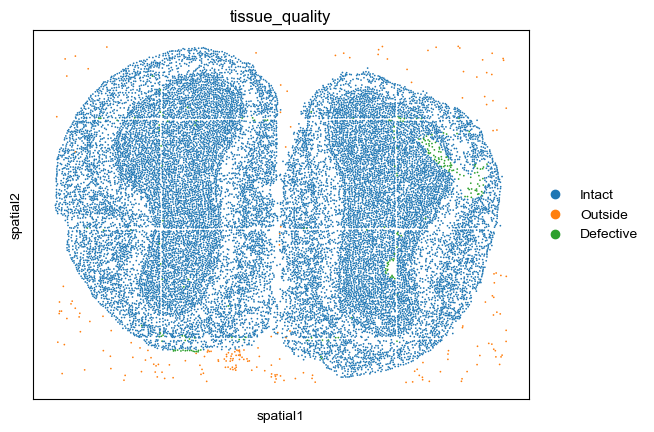

In [4]:
def square_selector(x_min, x_max, y_min, y_max):
    selector = pd.Series([False] * adata.shape[0])
    selector[(adata.obsm['spatial'][:, 0] > x_min) & (adata.obsm['spatial'][:, 0] < x_max) &\
        (adata.obsm['spatial'][:, 1] > y_min) & (adata.obsm['spatial'][:, 1] < y_max)] = True
    return selector.to_numpy()
# Identifying cells that inside the Tissue and with defects
adata.obs["tissue_quality"] = adata.obs["tissue_quality"].cat.add_categories("Defective")
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(10400, 11800, 11050, 14000)] = "Defective"
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(11000, 12000, 12500, 13400)] = "Defective"
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(9400, 10800, 10300, 14500)] = "Defective"
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(6600, 9100, 11200, 14000)] = "Defective"
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(7400, 8800, 10700, 14500)] = "Defective"
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Outside").to_numpy() & square_selector(7800, 8200, 10550, 10600)] = "Defective"
sc.pl.embedding(adata, color="tissue_quality", basis="spatial")

In [6]:
adata.write_h5ad(f"{trial_name}/data/olfa-stereoseq/data.h5ad")

In [7]:
adata = sc.read_h5ad("/media/share/STForte/data/olfa-stereoseq/data.h5ad")
sc.pp.filter_genes(adata, min_cells=5)
lowgene_selector = ~sc.pp.filter_cells(adata, min_genes=50, inplace=False)[0]
adata.obs["tissue_quality"][(adata.obs["tissue_quality"] == "Intact").to_numpy() & lowgene_selector] = "Defective"
adata

AnnData object with n_obs × n_vars = 19326 × 22780
    obs: 'tissue_quality', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [8]:
stgraph = STGraph.graphFromAnndata(adata=adata, 
                                   knn=True,  # Directly initializing knn for non-lattice data.
                                   k=18)
mask_idx = (adata.obs['tissue_quality'] == 'Defective').to_numpy()  # mask low quality cells
stgraph.mask_nodes(mask_idx=mask_idx)
stgraph.pca(svd_solver='torch', device='cuda')
gdata = stgraph.topyg()
print(f"The Data contians {gdata.x.size(0)} voxels, including {gdata.mask_idx.size(0)} masked voxels for imputation.")

brute-force knn initialize:   0%|          | 0/19326 [00:00<?, ?it/s]

PCA pre-compression for data, from 22780 onto 300-dim.
Scaling data: None; SVD solver: torch; random_state=42.
Start compression...	Done! Elapsed time: 29.50s.
The Data contians 19326 voxels, including 538 masked voxels for imputation.


## Model setup and training

In [9]:
model = STForteModel(adata=adata, gdata=gdata, epochs=500,
                     output_dir='./{:s}/pl_ckpts/'.format(trial_name),
                     module_kwargs=dict(partial_adjacent=True))
model.fit()

Global seed set to 42
/home/chunxuan/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_a82f7c | 71.9 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     To

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [10]:
if not os.path.exists(f"{trial_name}/data"):
    os.makedirs(f"{trial_name}/data")
save_gdata(gdata, path=f"{trial_name}/data/gdata.pkl")
adata.write_h5ad(f"{trial_name}/data/trial.h5ad")
model.save_state_dict(f'./{trial_name}/models/', alias="STForteModel_olfa_stereoseq")

In [11]:
model.get_latent_original(adata)
if not os.path.exists(f"./{trial_name}/outputs"):
    os.makedirs(f"./{trial_name}/outputs")
adata.write(f"./{trial_name}/outputs/stforte.h5ad")
adata_sp = model.get_result_anndata(adj_mat=False)  # Adjacent Mat is not available when 'partial_adjacent=True'.
adata_sp.write_h5ad("./{:s}/outputs/sp.h5ad".format(trial_name))

## Spatial domain identification

In [12]:
sc.pp.neighbors(adata, use_rep="STForte_COMB")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.23)

<AxesSubplot:title={'center':'leiden'}, xlabel='spatial1', ylabel='spatial2'>

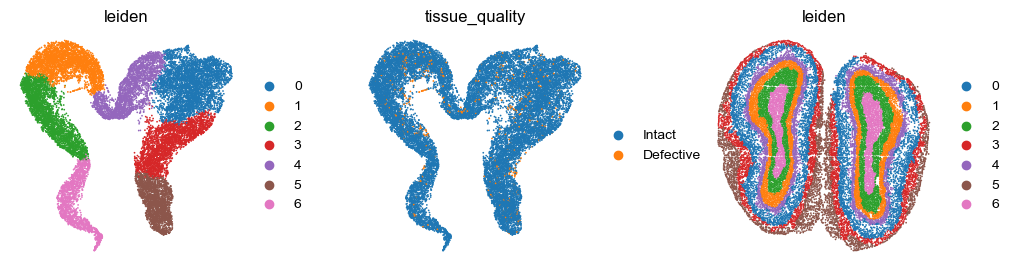

In [13]:
ncols, nrows = 3, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color="leiden", show=False, frameon=False, ax=axs[0])
sc.pl.umap(adata, color="tissue_quality", show=False, frameon=False, ax=axs[1])
sc.pl.embedding(adata, color="leiden", basis="spatial", show=False, frameon=False, ax=axs[2])
